In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [3]:
CLASS_NAMES= ['healthy', 'mild', 'moderate', 'severe']
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
NUM_CLASSES = len(CLASS_NAMES)

# **ResNET**

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#load data
data_x = np.load('fractal_data_x_original.npy') #images
data_y = np.load('fractal_data_y_original.npy') #labels
TOTAL_IMAGES = len(data_y)
print("TOTAL_IMAGES = ", TOTAL_IMAGES)

TOTAL_IMAGES =  5032


In [6]:
# scale pixels
def prep_pixels(train, test, validation):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    validation_norm = validation.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    validation_norm = validation_norm / 255.0
    # return normalized images
    return train_norm, test_norm, validation_norm

# **Splitting data in train - validation - test**

In [7]:
#percentage of the dataset which will be on TRAIN - TEST - VALIDATION
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.1
VALIDATION_PERCENTAGE = 0.1

In [8]:
train_size = int(TRAIN_PERCENTAGE * TOTAL_IMAGES)
test_size = int(TEST_PERCENTAGE * TOTAL_IMAGES)
validation_size = int(VALIDATION_PERCENTAGE * TOTAL_IMAGES)

In [9]:
train_x = data_x[:train_size]
train_y = data_y[:train_size]
data_x = data_x[train_size:]
data_y = data_y[train_size:]

test_x = data_x[:test_size]
test_y = data_y[:test_size]
data_x = data_x[test_size:]
data_y = data_y[test_size:]

validation_x = data_x #all the remainder we can let on validation
validation_y = data_y
del data_x
del data_y

In [10]:
print("train_size = ", len(train_y))
print("test_size = ", len(test_y))
print("validation_size = ", len(validation_y))

train_size =  4025
test_size =  503
validation_size =  504


In [11]:
train_x, test_x, validation_x = prep_pixels(train_x, test_x, validation_x)

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from IPython.display import SVG
import scipy.misc

In [14]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications import EfficientNetB6
# from tensorflow.keras.applications import EfficientNetB7
# from tensorflow.keras.applications import *

In [15]:
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [16]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH, CHANNELS),
    pooling=None,
    classes=NUM_CLASSES,
   # classifier_activation="softmax",
#    **kwargs
)

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

new_model = models.Sequential()
new_model.add(model)
#3rd conv layer
new_model.add(tf.keras.layers.Conv2D(32, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#4th conv layer
new_model.add(tf.keras.layers.Conv2D(64, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#Flatten Layer
new_model.add(tf.keras.layers.Flatten())

new_model.add(tf.keras.layers.Dense(128, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.Dropout(0.2))
#new_model.add(tf.keras.layers.l2( l=0.01))
#new_model.add(layers.GlobalAveragePooling2D())
#output Dense Layer
new_model.add(tf.keras.layers.Dense(NUM_CLASSES))
new_model.add(tf.keras.layers.Activation('softmax'))
adam = tf.keras.optimizers.Adam(lr=0.001)


C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          589856    
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          1

In [19]:
epochs = 300

#compila e treina o modelo com os dados carregados
new_model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=adam)
model_trained = new_model.fit(train_x, train_y,epochs=epochs,verbose=2,validation_data=(validation_x, validation_y),shuffle=False)

Epoch 1/300
126/126 - 56s - loss: 2.1888 - acc: 0.2686 - val_loss: 1.9290 - val_acc: 0.2619 - 56s/epoch - 445ms/step
Epoch 2/300
126/126 - 36s - loss: 1.8850 - acc: 0.2512 - val_loss: 1.7333 - val_acc: 0.2619 - 36s/epoch - 289ms/step
Epoch 3/300
126/126 - 36s - loss: 1.7208 - acc: 0.2383 - val_loss: 1.6161 - val_acc: 0.2282 - 36s/epoch - 288ms/step
Epoch 4/300
126/126 - 36s - loss: 1.6280 - acc: 0.2648 - val_loss: 1.5451 - val_acc: 0.2282 - 36s/epoch - 289ms/step
Epoch 5/300
126/126 - 36s - loss: 1.5636 - acc: 0.2460 - val_loss: 31.0225 - val_acc: 0.2500 - 36s/epoch - 289ms/step
Epoch 6/300
126/126 - 36s - loss: 1.5249 - acc: 0.2407 - val_loss: 1.4661 - val_acc: 0.2282 - 36s/epoch - 290ms/step
Epoch 7/300
126/126 - 37s - loss: 1.4985 - acc: 0.2579 - val_loss: 1.4472 - val_acc: 0.2282 - 37s/epoch - 292ms/step
Epoch 8/300
126/126 - 37s - loss: 1.4692 - acc: 0.2475 - val_loss: 1.4302 - val_acc: 0.2401 - 37s/epoch - 294ms/step
Epoch 9/300
126/126 - 37s - loss: 1.4613 - acc: 0.2425 - val_lo

Epoch 71/300
126/126 - 38s - loss: 1.2343 - acc: 0.3769 - val_loss: 1.3022 - val_acc: 0.3373 - 38s/epoch - 298ms/step
Epoch 72/300
126/126 - 37s - loss: 1.2233 - acc: 0.3834 - val_loss: 1.2940 - val_acc: 0.3730 - 37s/epoch - 296ms/step
Epoch 73/300
126/126 - 37s - loss: 1.2145 - acc: 0.3911 - val_loss: 1.2835 - val_acc: 0.3373 - 37s/epoch - 295ms/step
Epoch 74/300
126/126 - 37s - loss: 1.2050 - acc: 0.3938 - val_loss: 1.3743 - val_acc: 0.3234 - 37s/epoch - 294ms/step
Epoch 75/300
126/126 - 37s - loss: 1.2057 - acc: 0.4030 - val_loss: 1.3135 - val_acc: 0.3294 - 37s/epoch - 294ms/step
Epoch 76/300
126/126 - 37s - loss: 1.1747 - acc: 0.4191 - val_loss: 1.2755 - val_acc: 0.3373 - 37s/epoch - 294ms/step
Epoch 77/300
126/126 - 37s - loss: 1.1674 - acc: 0.4268 - val_loss: 1.2727 - val_acc: 0.3988 - 37s/epoch - 294ms/step
Epoch 78/300
126/126 - 37s - loss: 1.1535 - acc: 0.4370 - val_loss: 1.3993 - val_acc: 0.3155 - 37s/epoch - 294ms/step
Epoch 79/300
126/126 - 37s - loss: 1.1307 - acc: 0.4591 

126/126 - 37s - loss: 0.3738 - acc: 0.8586 - val_loss: 1.9621 - val_acc: 0.4345 - 37s/epoch - 295ms/step
Epoch 141/300
126/126 - 37s - loss: 0.3718 - acc: 0.8720 - val_loss: 2.7874 - val_acc: 0.4048 - 37s/epoch - 296ms/step
Epoch 142/300
126/126 - 37s - loss: 0.3481 - acc: 0.8760 - val_loss: 2.3234 - val_acc: 0.4385 - 37s/epoch - 297ms/step
Epoch 143/300
126/126 - 37s - loss: 0.3471 - acc: 0.8790 - val_loss: 2.2443 - val_acc: 0.4067 - 37s/epoch - 295ms/step
Epoch 144/300
126/126 - 37s - loss: 0.3006 - acc: 0.8927 - val_loss: 2.6571 - val_acc: 0.3571 - 37s/epoch - 296ms/step
Epoch 145/300
126/126 - 37s - loss: 0.3222 - acc: 0.8860 - val_loss: 2.4452 - val_acc: 0.4048 - 37s/epoch - 296ms/step
Epoch 146/300
126/126 - 37s - loss: 0.3026 - acc: 0.8919 - val_loss: 2.4923 - val_acc: 0.3750 - 37s/epoch - 295ms/step
Epoch 147/300
126/126 - 37s - loss: 0.3106 - acc: 0.8882 - val_loss: 2.4506 - val_acc: 0.4147 - 37s/epoch - 294ms/step
Epoch 148/300
126/126 - 37s - loss: 0.2594 - acc: 0.9108 - val

Epoch 209/300
126/126 - 38s - loss: 0.0821 - acc: 0.9816 - val_loss: 2.7164 - val_acc: 0.4484 - 38s/epoch - 300ms/step
Epoch 210/300
126/126 - 38s - loss: 0.0997 - acc: 0.9747 - val_loss: 2.9814 - val_acc: 0.4365 - 38s/epoch - 300ms/step
Epoch 211/300
126/126 - 38s - loss: 0.0754 - acc: 0.9843 - val_loss: 2.7998 - val_acc: 0.4921 - 38s/epoch - 299ms/step
Epoch 212/300
126/126 - 38s - loss: 0.0721 - acc: 0.9816 - val_loss: 2.5840 - val_acc: 0.5000 - 38s/epoch - 300ms/step
Epoch 213/300
126/126 - 38s - loss: 0.0875 - acc: 0.9771 - val_loss: 2.9573 - val_acc: 0.4385 - 38s/epoch - 300ms/step
Epoch 214/300
126/126 - 38s - loss: 0.0693 - acc: 0.9821 - val_loss: 2.6509 - val_acc: 0.4643 - 38s/epoch - 300ms/step
Epoch 215/300
126/126 - 38s - loss: 0.0660 - acc: 0.9848 - val_loss: 3.1952 - val_acc: 0.4742 - 38s/epoch - 300ms/step
Epoch 216/300
126/126 - 38s - loss: 0.0762 - acc: 0.9799 - val_loss: 2.6873 - val_acc: 0.4444 - 38s/epoch - 300ms/step
Epoch 217/300
126/126 - 38s - loss: 0.1082 - acc

Epoch 278/300
126/126 - 38s - loss: 0.0673 - acc: 0.9831 - val_loss: 2.6653 - val_acc: 0.4643 - 38s/epoch - 300ms/step
Epoch 279/300
126/126 - 38s - loss: 0.0905 - acc: 0.9774 - val_loss: 2.8884 - val_acc: 0.4683 - 38s/epoch - 300ms/step
Epoch 280/300
126/126 - 38s - loss: 0.0894 - acc: 0.9781 - val_loss: 2.5411 - val_acc: 0.4405 - 38s/epoch - 299ms/step
Epoch 281/300
126/126 - 38s - loss: 0.0631 - acc: 0.9839 - val_loss: 2.4664 - val_acc: 0.4405 - 38s/epoch - 299ms/step
Epoch 282/300
126/126 - 38s - loss: 0.0432 - acc: 0.9923 - val_loss: 2.9307 - val_acc: 0.4722 - 38s/epoch - 299ms/step
Epoch 283/300
126/126 - 38s - loss: 0.0408 - acc: 0.9920 - val_loss: 2.7339 - val_acc: 0.4683 - 38s/epoch - 300ms/step
Epoch 284/300
126/126 - 38s - loss: 0.0359 - acc: 0.9930 - val_loss: 2.4365 - val_acc: 0.4861 - 38s/epoch - 299ms/step
Epoch 285/300
126/126 - 38s - loss: 0.0359 - acc: 0.9928 - val_loss: 2.8954 - val_acc: 0.4524 - 38s/epoch - 300ms/step
Epoch 286/300
126/126 - 38s - loss: 0.0427 - acc

In [20]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [21]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [22]:
#print(getLayerIndexByName(new_model, 'flatten_1')) #just used to get the index of flatten layer

In [23]:
model_name = f'resnet50-fractal_baseline-holdout-{epochs}epochs_normalized.npy'
new_model.save(model_name)

INFO:tensorflow:Assets written to: resnet50-fractal_baseline-holdout-300epochs_normalized.npy\assets


INFO:tensorflow:Assets written to: resnet50-fractal_baseline-holdout-300epochs_normalized.npy\assets


# **Random Forest - flatting**

In [24]:
new_model_rf = keras.Model(inputs=new_model.input, outputs=new_model.get_layer(index=9).output)
featureVector = new_model_rf.predict(train_x)

126/126 [==============================] - 11s 76ms/step


In [25]:
featureVector2 = new_model_rf.predict(test_x)

16/16 [==============================] - 2s 108ms/step


In [26]:
print(featureVector.shape)

(4025, 64)


In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(featureVector,train_y)



RandomForestClassifier()

In [29]:
test_x.shape

(503, 128, 128, 3)

In [30]:
y_pred=clf.predict(featureVector2)

In [31]:
featureVector.shape

(4025, 64)

In [32]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.5566600397614314


In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
clf = DecisionTreeClassifier(random_state=0)

# **Testes**

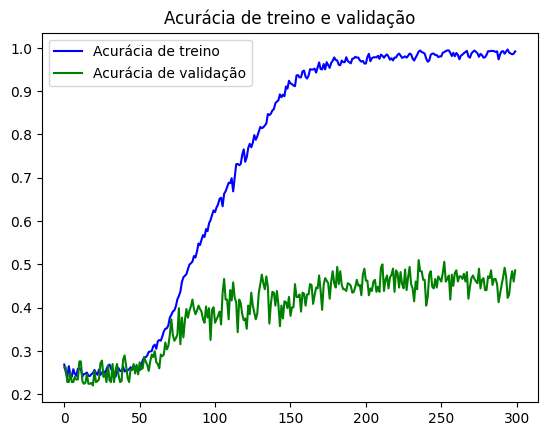

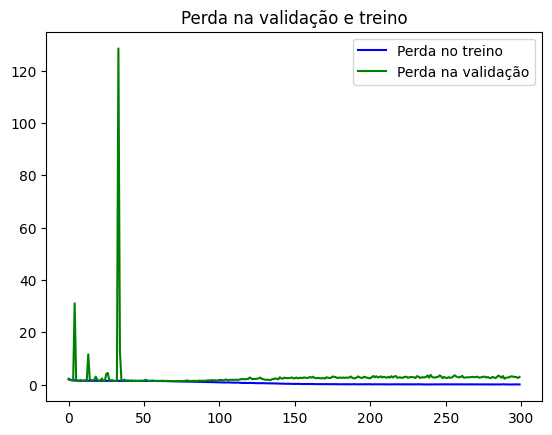

In [35]:
import matplotlib.pyplot as plt

accuracy = model_trained.history['acc']
val_accuracy = model_trained.history['val_acc']
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Acurácia de treino')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Perda no treino')
plt.plot(epochs, val_loss, 'g', label='Perda na validação')
plt.title('Perda na validação e treino')
plt.legend()
plt.show()

In [36]:
#avalia a fase de teste

model_loss, model_accuracy = new_model.evaluate(test_x, test_y, verbose=1)

#mostra o resultado
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

16/16 [==============================] - 1s 81ms/step - loss: 2.9303 - acc: 0.4831
Test loss: 2.9303488731384277
Test accuracy: 0.48310139775276184


In [37]:
#faz a predição das imagens

from tensorflow.keras.utils import to_categorical

pred = new_model.predict(test_x, verbose=0)

pred_probs = np.argmax(pred,axis=1)

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [39]:
cm = confusion_matrix(test_y, pred_probs)

In [40]:
#gera os valores de falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

f1score = f1_score(test_y, pred_probs, average='weighted')
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)


print("F1 Score:", f1score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:  ", precision)
print("Accuracy:   ", accuracy)

F1 Score: 0.4764714529514277
Sensitivity: [0.640625   0.61111111 0.23387097 0.44      ]
Specificity: [0.84533333 0.60212202 0.94986807 0.91269841]
Precision:   [0.58571429 0.33920705 0.60416667 0.625     ]
Accuracy:    [0.79324056 0.60437376 0.77335984 0.79522863]
